In [1]:
from scipy import stats
import numpy as np

# Version with step-by-step loss

In [2]:
# Dict to convert movement idx to actual movement coordinates
idx2mov = {0:np.array([1,0], dtype=int), 
           1:np.array([-1,0], dtype=int), 
           2:np.array([0,1], dtype=int), 
           3:np.array([0,-1], dtype=int)}

# Convert coordinate to flattened idx
def loc2idx(loc, grid_size=np.array([5, 5], dtype=int)):
    return loc[0]*grid_size[0] + loc[1]

# Convert location flattened idx to coordinate
def idx2loc(idx, grid_size=np.array([5, 5], dtype=int)):
    return np.array([idx // grid_size[0], idx % grid_size[0]], dtype=int)


def sample_n_back_spatial(n, p_stop=0.05, max_length=40, grid_size=np.array([5, 5], dtype=int), boundary='periodic', return_trajectory=False):
    """
    Function to generate a sample for the n-back spatial task.

    Args:
    - n: response delay
    - p_stop: after n steps, probability of stoping walk (default=0.05)
    - max_length: maximum trajectory length (left zero-padding is applied to reach this length)
    - grid_size (array-like): size of gridworld, must be odd (default=[5,5])
    - boundary ['periodic', 'strict']: boundary conditions
    - return_trajectory (bool): whether to return trajectory

    Returns: movements (1D array, as index), n_back_idx (n-back location as idx), (trajectory) 
    
    """
    assert boundary in ['periodic', 'strict'], "boundary must be either 'periodic' or 'strict'"
    assert (grid_size[0] % 2 == 1) & (grid_size[1] % 2 == 1), "grid size must be odd"

    zero = np.array([(grid_size[0]-1)//2, (grid_size[1]-1)//2], dtype=int)
    movements = np.random.randint(4, size=max_length)
    
    trajectory = [zero]
    
    for idx in movements:
        if boundary == 'periodic':
            trajectory.append((trajectory[-1] + idx2mov[idx]) % grid_size)
        elif boundary == 'strict':
            trajectory.append(np.clip(trajectory[-1] + idx2mov[idx], a_min=[0,0], a_max=grid_size-1))
        
    trajectory = np.array(trajectory)

    n_back_idx = np.array([loc2idx(trajectory[i], grid_size=grid_size) for i in range(max_length-n)])

    if return_trajectory:
        return movements, n_back_idx, trajectory
    else:
        return movements, n_back_idx


In [3]:
sample_n_back_spatial(2, boundary='strict')

(array([1, 2, 0, 1, 2, 0, 3, 3, 2, 1, 2, 3, 1, 1, 3, 1, 0, 1, 2, 1, 3, 0,
        3, 2, 3, 2, 3, 2, 2, 3, 1, 2, 2, 3, 2, 1, 3, 0, 1, 1]),
 array([12,  7,  8, 13,  8,  9, 14, 13, 12, 13,  8,  9,  8,  3,  3,  2,  2,
         7,  2,  3,  3,  2,  7,  6,  7,  6,  7,  6,  7,  8,  7,  2,  3,  4,
         3,  4,  4,  3]))

In [4]:
from torch.utils.data import Dataset, DataLoader
import torch

class NBackDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)
		
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

def create_n_back_dataset(num_samples, n, p_stop=0.05, max_length=40, grid_size=np.array([5, 5], dtype=int), boundary='periodic'):
    X, Y = [], []
    for _ in range(num_samples):
        x, y = sample_n_back_spatial(n, p_stop=p_stop, max_length=max_length, grid_size=grid_size, boundary=boundary)
        X.append(x); Y.append(y)

    X = np.vstack(X)
    Y = np.vstack(Y)

    X = torch.tensor(X, dtype=int)
    Y = torch.tensor(Y, dtype=int)

    return NBackDataset(X, Y)

In [5]:
data = create_n_back_dataset(100, 3)
data[0][1].size()

torch.Size([37])

In [6]:
import torch.nn.functional as F
from torch import nn

class GRUExplorer(nn.Module):
    
    def __init__(self, n_back, hidden_state_size, num_layers=1, grid_size=np.array([5, 5], dtype=int), dropout=0.2):

        super(GRUExplorer, self).__init__()

        self.n_back = n_back
        self.hidden_state_size = hidden_state_size
        self.output_size = grid_size[0]*grid_size[1]
        self.num_layers = num_layers

        self.core = nn.GRU(4, self.hidden_state_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.head = nn.Linear(self.hidden_state_size, self.output_size)

    def forward(self, X, return_hidden=False):

        X = F.one_hot(X, num_classes=4).to(torch.float32)
        h0 = torch.zeros(self.num_layers, X.size(0), self.hidden_state_size).to(X.device)

        if return_hidden:
            states, hidden = self.core(X, h0)
        else:
            states, _= self.core(X, h0)
        
        logits = self.head(self.dropout(states[:, self.n_back:, :]))
        
        if return_hidden:
            return torch.softmax(logits, -1).transpose(1,2), hidden
        else:
            return torch.softmax(logits, -1).transpose(1,2)

In [38]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    loss_list = []
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_list.append(loss.item())

    return np.mean(loss_list)
#            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).mean().item()
    test_loss /= num_batches
    correct /= num_batches
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct, test_loss

In [8]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [29]:
from torch import optim
from torch.optim.lr_scheduler import ExponentialLR

batch_size = 1000
epochs = 200
train_sample_size = 100_000
test_sample_size = 10_000

n_back = 10
hidden_units = 128
num_layers = 1
lr = 0.001

def sample_and_train(n_back, hidden_units, num_layers=1, train_sample_size=100_000, test_sample_size=10_000, batch_size=1000, epochs=100, lr=0.001, dropout=0.2, l2_reg=0.):

    train_dataloader = DataLoader(create_n_back_dataset(train_sample_size, n_back, boundary='strict'), batch_size=batch_size)
    test_dataloader = DataLoader(create_n_back_dataset(test_sample_size, n_back, boundary='strict'), batch_size=batch_size)
        
    
    model = GRUExplorer(n_back, hidden_units, num_layers=num_layers).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2_reg)
    # scheduler = ExponentialLR(optimizer, gamma=0.9)
    
    acc, test_loss, train_loss = [], [], []
    
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        tr = train(train_dataloader, model, loss_fn, optimizer)
        a, t = test(test_dataloader, model, loss_fn)
        acc.append(a); test_loss.append(t); train_loss.append(tr)
    #    scheduler.step()
    print("Done!")

    return model, acc, test_loss, train_loss

In [ ]:
_, acc, test_loss, train_loss = sample_and_train(0, 128, dropout=0.2, l2_reg=0.0001, lr=0.0001)

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 5.2%, Avg loss: 3.218128 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 8.6%, Avg loss: 3.215203 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 9.9%, Avg loss: 3.196893 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 11.2%, Avg loss: 3.172713 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 15.6%, Avg loss: 3.148105 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 25.6%, Avg loss: 3.091752 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 33.1%, Avg loss: 3.021795 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 39.2%, Avg loss: 2.981630 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 44.5%, Avg loss: 2.948542 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 47.7%, Avg loss: 2.920323 

Epoch 11
-------------------------------


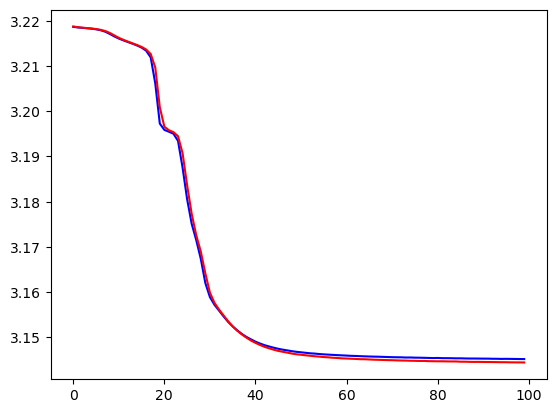

In [52]:
import matplotlib.pyplot as plt

plt.plot(test_loss, color='b')
plt.plot(train_loss, color='r')

In [25]:
import itertools as itt
from tqdm import tqdm

list_hidden_units = [64, 128, 258]#, 512]
list_num_layers = [1, 2, 3]#, 4]
list_lr = [0.01, 0.005, 0.001, 0.005, 0.0001]
n_trials = 1

grid_dict = { 
    'acc' : [],
    'test_loss' : [],
    'train_loss': [],
    'hidden_units' : [],
    'num_layers' : [],
    'lr' : [],
    'trial' : []
}

for hidden_units, num_layers, lr, trial in tqdm(itt.product(list_hidden_units, list_num_layers, list_lr, range(n_trials))):

    print(f"Computing with {hidden_units} hidden units, {num_layers} layers, lr={lr} - trial {trial}")
    _, acc, test_loss, train_loss = sample_and_train(0, hidden_units, num_layers=num_layers, lr=lr)

    grid_dict['acc'].append(np.array(acc))
    grid_dict['test_loss'].append(np.array(test_loss))
    grid_dict['train_loss'].append(np.array(train_loss))
    grid_dict['hidden_units'].append(hidden_units)
    grid_dict['num_layers'].append(num_layers)
    grid_dict['lr'].append(lr)
    grid_dict['trial'].append(trial)
    

0it [00:00, ?it/s]/home/ikarmann/anaconda3/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1
-------------------------------
Test Error: 
 Accuracy: 78.6%, Avg loss: 2.598806 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 91.9%, Avg loss: 2.374053 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 91.9%, Avg loss: 2.366878 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 91.9%, Avg loss: 2.365587 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 91.9%, Avg loss: 2.365177 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 91.9%, Avg loss: 2.364993 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 91.9%, Avg loss: 2.364870 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 91.9%, Avg loss: 2.364822 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 91.9%, Avg loss: 2.364748 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 91.9%, Avg loss: 2.364713 

Epoch 11
-------------------------------
Test Error: 
 Accuracy: 91.9%, Avg los

1it [02:06, 126.47s/it]

Test Error: 
 Accuracy: 91.9%, Avg loss: 2.364445 

Done!
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 69.3%, Avg loss: 2.730771 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 84.2%, Avg loss: 2.469664 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 84.6%, Avg loss: 2.444244 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 84.6%, Avg loss: 2.440114 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 84.6%, Avg loss: 2.439100 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 84.6%, Avg loss: 2.438036 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 84.6%, Avg loss: 2.437725 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 84.6%, Avg loss: 2.437530 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 84.6%, Avg loss: 2.437392 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 84.6%, Avg loss: 2.437292 

Epoch 11
------------

2it [04:14, 127.39s/it]

Test Error: 
 Accuracy: 84.6%, Avg loss: 2.436465 

Done!
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 25.2%, Avg loss: 3.086962 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 54.1%, Avg loss: 2.900476 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 78.6%, Avg loss: 2.693604 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 83.6%, Avg loss: 2.551128 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 84.2%, Avg loss: 2.491216 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 84.3%, Avg loss: 2.466886 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 84.3%, Avg loss: 2.455805 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 84.3%, Avg loss: 2.450105 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 84.3%, Avg loss: 2.446818 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 84.3%, Avg loss: 2.444825 

Epoch 11
------------

3it [06:21, 127.27s/it]

Test Error: 
 Accuracy: 84.3%, Avg loss: 2.438985 

Done!
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 76.1%, Avg loss: 2.713754 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 95.3%, Avg loss: 2.382828 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 95.9%, Avg loss: 2.335119 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 95.9%, Avg loss: 2.329306 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 95.9%, Avg loss: 2.327464 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 95.9%, Avg loss: 2.326643 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 95.9%, Avg loss: 2.326223 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 95.9%, Avg loss: 2.325981 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 95.9%, Avg loss: 2.325825 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 95.9%, Avg loss: 2.325727 

Epoch 11
------------

4it [08:33, 128.92s/it]

Test Error: 
 Accuracy: 95.9%, Avg loss: 2.325357 

Done!
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 7.1%, Avg loss: 3.218197 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 7.0%, Avg loss: 3.216667 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 12.1%, Avg loss: 3.204167 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 18.0%, Avg loss: 3.181665 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 21.2%, Avg loss: 3.145252 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 23.8%, Avg loss: 3.112560 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 27.8%, Avg loss: 3.084796 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 32.5%, Avg loss: 3.059157 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 34.3%, Avg loss: 3.035745 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 36.0%, Avg loss: 3.015287 

Epoch 11
--------------

5it [10:36, 127.11s/it]

Test Error: 
 Accuracy: 72.9%, Avg loss: 2.551881 

Done!
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 79.2%, Avg loss: 2.511551 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 83.5%, Avg loss: 2.448272 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 91.9%, Avg loss: 2.365207 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 91.9%, Avg loss: 2.364925 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 81.7%, Avg loss: 2.471735 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 91.9%, Avg loss: 2.365145 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 91.9%, Avg loss: 2.364855 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 91.9%, Avg loss: 2.364764 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 91.9%, Avg loss: 2.364731 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 91.9%, Avg loss: 2.364708 

Epoch 11
------------

6it [13:03, 133.62s/it]

Test Error: 
 Accuracy: 29.3%, Avg loss: 2.990675 

Done!
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 70.0%, Avg loss: 2.629443 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 87.2%, Avg loss: 2.417318 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 87.9%, Avg loss: 2.405355 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 87.9%, Avg loss: 2.404583 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 87.9%, Avg loss: 2.404129 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 87.9%, Avg loss: 2.403990 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 87.9%, Avg loss: 2.403885 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 87.9%, Avg loss: 2.403955 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 87.9%, Avg loss: 2.403781 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 87.9%, Avg loss: 2.403726 

Epoch 11
------------

7it [15:31, 138.32s/it]

Test Error: 
 Accuracy: 91.9%, Avg loss: 2.364249 

Done!
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 36.9%, Avg loss: 3.001534 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 63.6%, Avg loss: 2.745821 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 75.4%, Avg loss: 2.579293 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 79.4%, Avg loss: 2.511438 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 80.1%, Avg loss: 2.491621 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 80.3%, Avg loss: 2.484020 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 80.2%, Avg loss: 2.483287 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 80.4%, Avg loss: 2.480294 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 88.5%, Avg loss: 2.402659 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 88.5%, Avg loss: 2.400859 

Epoch 11
------------

8it [17:58, 141.24s/it]

Test Error: 
 Accuracy: 96.6%, Avg loss: 2.318711 

Done!
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 70.1%, Avg loss: 2.629095 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 83.3%, Avg loss: 2.454155 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 83.8%, Avg loss: 2.445058 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 83.8%, Avg loss: 2.444412 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 83.8%, Avg loss: 2.444122 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 83.8%, Avg loss: 2.443997 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 83.8%, Avg loss: 2.443998 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 76.5%, Avg loss: 2.522152 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 83.7%, Avg loss: 2.447136 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 83.8%, Avg loss: 2.444450 

Epoch 11
------------

9it [20:21, 141.80s/it]

Test Error: 
 Accuracy: 91.9%, Avg loss: 2.364432 

Done!
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 3.7%, Avg loss: 3.218019 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 9.4%, Avg loss: 3.206292 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 17.9%, Avg loss: 3.157943 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 24.4%, Avg loss: 3.098094 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 29.3%, Avg loss: 3.056189 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 32.2%, Avg loss: 3.020411 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 35.4%, Avg loss: 2.987639 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 42.1%, Avg loss: 2.952748 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 46.9%, Avg loss: 2.916169 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 50.7%, Avg loss: 2.881081 

Epoch 11
--------------

10it [22:48, 143.43s/it]

Test Error: 
 Accuracy: 92.9%, Avg loss: 2.357728 

Done!
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 82.0%, Avg loss: 2.470809 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 71.4%, Avg loss: 2.573707 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 83.9%, Avg loss: 2.444739 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 83.9%, Avg loss: 2.443810 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 83.9%, Avg loss: 2.443439 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 83.9%, Avg loss: 2.443347 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 83.8%, Avg loss: 2.445992 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 83.9%, Avg loss: 2.443671 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 83.9%, Avg loss: 2.443423 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 83.9%, Avg loss: 2.443314 

Epoch 11
------------

11it [25:54, 156.44s/it]

Test Error: 
 Accuracy: 47.5%, Avg loss: 2.802323 

Done!
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 73.9%, Avg loss: 2.574751 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 87.7%, Avg loss: 2.409291 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 88.3%, Avg loss: 2.401353 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 88.3%, Avg loss: 2.400712 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 88.3%, Avg loss: 2.400694 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 88.3%, Avg loss: 2.400458 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 88.3%, Avg loss: 2.400369 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 88.3%, Avg loss: 2.400329 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 88.3%, Avg loss: 2.400318 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 88.3%, Avg loss: 2.400277 

Epoch 11
------------

12it [28:53, 163.13s/it]

Test Error: 
 Accuracy: 88.3%, Avg loss: 2.400253 

Done!
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 40.4%, Avg loss: 2.991373 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 66.9%, Avg loss: 2.673387 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 76.5%, Avg loss: 2.529932 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 80.4%, Avg loss: 2.484093 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 84.9%, Avg loss: 2.436957 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 85.0%, Avg loss: 2.435444 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 84.9%, Avg loss: 2.434858 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 85.0%, Avg loss: 2.434302 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 85.0%, Avg loss: 2.434071 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 85.0%, Avg loss: 2.433868 

Epoch 11
------------

13it [31:49, 167.26s/it]

Test Error: 
 Accuracy: 92.2%, Avg loss: 2.361389 

Done!
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 81.8%, Avg loss: 2.501050 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 92.2%, Avg loss: 2.363527 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 92.2%, Avg loss: 2.363086 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 92.3%, Avg loss: 2.361792 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 91.6%, Avg loss: 2.367917 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 92.3%, Avg loss: 2.361517 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 92.3%, Avg loss: 2.361436 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 92.3%, Avg loss: 2.361484 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 92.2%, Avg loss: 2.362965 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 92.3%, Avg loss: 2.361495 

Epoch 11
------------

14it [34:50, 171.26s/it]

Test Error: 
 Accuracy: 92.3%, Avg loss: 2.361224 

Done!
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 7.0%, Avg loss: 3.216721 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 11.8%, Avg loss: 3.187168 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 13.7%, Avg loss: 3.165658 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 18.7%, Avg loss: 3.139850 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 24.4%, Avg loss: 3.091150 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 29.9%, Avg loss: 3.035994 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 42.6%, Avg loss: 2.977430 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 49.6%, Avg loss: 2.922301 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 55.3%, Avg loss: 2.869839 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 58.6%, Avg loss: 2.823121 

Epoch 11
-------------

15it [37:52, 174.60s/it]

Test Error: 
 Accuracy: 89.1%, Avg loss: 2.392779 

Done!
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 21.7%, Avg loss: 3.075642 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 38.4%, Avg loss: 2.903111 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 37.9%, Avg loss: 2.903955 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 30.0%, Avg loss: 2.986508 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 39.5%, Avg loss: 2.887729 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 43.2%, Avg loss: 2.849247 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 43.2%, Avg loss: 2.847338 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 43.2%, Avg loss: 2.846733 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 39.3%, Avg loss: 2.890705 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 42.5%, Avg loss: 2.856897 

Epoch 11
------------

16it [40:44, 173.77s/it]

Test Error: 
 Accuracy: 74.2%, Avg loss: 2.537909 

Done!
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 73.6%, Avg loss: 2.672243 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 87.7%, Avg loss: 2.428412 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 87.9%, Avg loss: 2.407496 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 87.9%, Avg loss: 2.405575 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 87.9%, Avg loss: 2.404834 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 87.9%, Avg loss: 2.404458 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 87.9%, Avg loss: 2.404255 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 87.9%, Avg loss: 2.404130 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 87.9%, Avg loss: 2.404036 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 87.9%, Avg loss: 2.403970 

Epoch 11
------------

17it [43:38, 173.90s/it]

Test Error: 
 Accuracy: 87.9%, Avg loss: 2.403628 

Done!
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 35.9%, Avg loss: 3.021475 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 66.3%, Avg loss: 2.804446 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 78.5%, Avg loss: 2.638912 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 83.2%, Avg loss: 2.524726 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 83.8%, Avg loss: 2.477538 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 83.9%, Avg loss: 2.460198 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 83.9%, Avg loss: 2.453183 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 83.9%, Avg loss: 2.449728 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 83.9%, Avg loss: 2.447799 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 83.9%, Avg loss: 2.446602 

Epoch 11
------------

18it [46:33, 173.98s/it]

Test Error: 
 Accuracy: 83.9%, Avg loss: 2.442817 

Done!
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 66.8%, Avg loss: 2.724584 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 94.9%, Avg loss: 2.360033 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 96.0%, Avg loss: 2.327948 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 96.0%, Avg loss: 2.326065 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 96.0%, Avg loss: 2.325342 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 96.0%, Avg loss: 2.324970 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 96.0%, Avg loss: 2.324761 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 96.0%, Avg loss: 2.324627 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 96.0%, Avg loss: 2.324535 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 96.0%, Avg loss: 2.324465 

Epoch 11
------------

19it [49:26, 173.96s/it]

Test Error: 
 Accuracy: 85.5%, Avg loss: 2.427528 

Done!
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 7.1%, Avg loss: 3.217378 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 13.8%, Avg loss: 3.198696 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 18.0%, Avg loss: 3.152875 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 27.0%, Avg loss: 3.095154 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 32.7%, Avg loss: 3.053922 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 34.3%, Avg loss: 3.022545 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 35.2%, Avg loss: 2.997502 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 40.2%, Avg loss: 2.971348 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 46.1%, Avg loss: 2.943214 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 52.1%, Avg loss: 2.912962 

Epoch 11
-------------

20it [52:22, 174.45s/it]

Test Error: 
 Accuracy: 72.9%, Avg loss: 2.551330 

Done!
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 76.3%, Avg loss: 2.522106 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 80.7%, Avg loss: 2.476350 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 80.7%, Avg loss: 2.475631 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 80.7%, Avg loss: 2.475343 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 80.3%, Avg loss: 2.480805 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 80.7%, Avg loss: 2.475678 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 80.7%, Avg loss: 2.475229 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 80.7%, Avg loss: 2.475244 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 80.7%, Avg loss: 2.474973 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 80.7%, Avg loss: 2.474905 

Epoch 11
------------

21it [57:05, 207.07s/it]

Test Error: 
 Accuracy: 77.2%, Avg loss: 2.509045 

Done!
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 80.2%, Avg loss: 2.524170 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 91.9%, Avg loss: 2.365966 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 91.9%, Avg loss: 2.364935 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 91.9%, Avg loss: 2.364592 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 91.9%, Avg loss: 2.364427 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 91.9%, Avg loss: 2.364343 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 91.9%, Avg loss: 2.364281 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 91.9%, Avg loss: 2.364244 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 91.9%, Avg loss: 2.364220 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 91.9%, Avg loss: 2.364201 

Epoch 11
------------

22it [1:01:40, 227.55s/it]

Test Error: 
 Accuracy: 88.3%, Avg loss: 2.400148 

Done!
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 53.8%, Avg loss: 2.875181 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 76.5%, Avg loss: 2.597640 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 87.8%, Avg loss: 2.431121 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 87.8%, Avg loss: 2.412606 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 87.8%, Avg loss: 2.408705 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 87.8%, Avg loss: 2.407139 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 87.8%, Avg loss: 2.406762 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 87.8%, Avg loss: 2.405959 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 87.8%, Avg loss: 2.405595 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 87.8%, Avg loss: 2.405383 

Epoch 11
------------

23it [1:06:17, 242.35s/it]

Test Error: 
 Accuracy: 87.8%, Avg loss: 2.404525 

Done!
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 74.2%, Avg loss: 2.573817 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 84.0%, Avg loss: 2.444513 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 84.0%, Avg loss: 2.442694 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 84.0%, Avg loss: 2.442370 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 84.0%, Avg loss: 2.442332 

Epoch 6
-------------------------------


23it [1:07:10, 175.26s/it]


KeyboardInterrupt: 

In [21]:
import pandas as pd

grid_df = pd.DataFrame(grid_dict)

grid_df.to_csv('0_back_grid_search.csv')

In [ ]:
grid_df.to_pickle('0_back_grid_search.pkl')